In [2]:
import os
import pandas as pd
import numpy as np
import math
import pymongo
import matplotlib.pyplot as plt
from matplotlib import mlab
import matplotlib.cm as cm
from skimage.transform import resize
import SignalFunctions
from sklearn import linear_model
from sklearn.utils import shuffle
import random
import threading

In [3]:
skipnum=50
fs=250
t=9
num=int(t*fs)
imagesize=80
batch_size=50
basefolder='D:/中大/spectro-temporal modelling for activity/data'+'/'
if os.path.exists(basefolder)==False:
    os.makedirs(basefolder)
cursor={}
batch = pd.DataFrame() 
print(num)

2250


In [4]:
def getsamples(sequences,collect,collection0):
    i=0
    batch = pd.DataFrame() 
    print(collect)
    outfolder=basefolder+collect+"/";
    if os.path.exists(outfolder)==False:
        os.makedirs(outfolder)
    for sequence in sequences:
        print(sequence)
        conditions0={}
        conditions0['NodeID']=PrimaryNode
        conditions0['SequenceID']=sequence
        count=math.floor((collection0.find(conditions0).count()-num)/skipnum)
        print(count)
        j=0
        while j<=count:
            
            cursor=collection0.find(conditions0).sort([('Time',pymongo.DESCENDING),('Counter',pymongo.DESCENDING)]).skip(j*skipnum).limit(num)
            j=j+1
            dataframe=list(cursor)
            if len(dataframe)<num:
                continue
            i=i+1
            behaviour=dataframe[0]['Behaviour']
            btime=dataframe[0]['Time']
            sec_cursor=collection0.find({'NodeID':SecondaryNode,'Time':{'$lte':btime}}).sort([('Time',pymongo.DESCENDING),('Counter',pymongo.DESCENDING)]).limit(num)
            secondary_dataframe=(list(sec_cursor))
            sec_I=pd.DataFrame(secondary_dataframe, columns=['I']).values
            sec_Q=pd.DataFrame(secondary_dataframe, columns=['Q']).values
            I=pd.DataFrame(dataframe, columns=['I']).values
            Q=pd.DataFrame(dataframe, columns=['Q']).values
            out=SignalFunctions.processing(I,Q,fs)
            sec_out=SignalFunctions.processing(sec_I,sec_Q,fs)
           
            #plt.imshow(out,cmap=cm.rainbow,extent=[0,t,-40,40],aspect='auto')
            #plt.show()
            plt.ylabel('Freqquency(Hz)')
            plt.xlabel('Time(sec)')
            plt.imshow(sec_out,cmap=cm.rainbow,extent=[0,t,-40,40],aspect='auto')
            plt.show()
            ts = np.arange(0, sec_I.shape[0], 1)
            plt.title('I') 
            plt.xlabel('Sequence')
            plt.ylabel('Amplitude')
            plt.plot(ts,sec_I)
            plt.show()
            plt.title('Q') 
            plt.xlabel('Sequence')
            plt.ylabel('Amplitude')
            plt.plot(ts,sec_Q)
            plt.show()
            out0=resize(out,(imagesize,imagesize))
            out1=np.reshape(out0,(imagesize,imagesize,1))
            sec_out0=resize(sec_out,(imagesize,imagesize))
            sec_out1=np.reshape(sec_out0,(imagesize,imagesize,1))
            final_out1=np.concatenate((out1, sec_out1), axis=2)
            signals=np.concatenate((I.T,Q.T,sec_I.T,sec_Q.T),axis=0)
            df = pd.DataFrame({"Spectrogram":[final_out1],"behaviour":[behaviour],'signals':[signals]})
            batch=batch.append(df,ignore_index=True)
            if i%batch_size==0:
                print(str(i))
                n=i/batch_size
                filename='batch%s_%s_%s.p'%(n,sequence,collect)
                save_path=outfolder+filename
                batch.to_pickle(save_path)
                batch = pd.DataFrame()  
            
    n=i/batch_size
    filename='batch%s_%s_%s.p'%(n,'o',collect)
    save_path=outfolder+filename
    batch.to_pickle(save_path)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: collection_names is deprecated. Use list_collection_names instead.
  


BumblebeeKitchen_26_09_2018
 
[13]
[]
BumblebeeKitchen_26_09_2018
BumblebeeKitchen_26_09_2018
BumblebeeKitchen_26_09_2018
BumblebeeKitchen_26_09_2018


13


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: count is deprecated. Use Collection.count_documents instead.
  del sys.path[0]


936


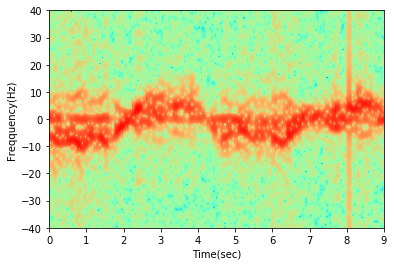

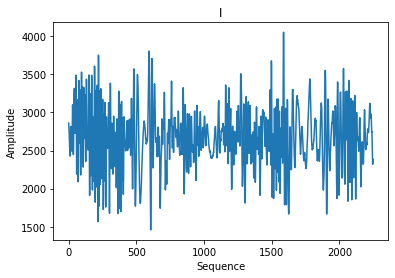

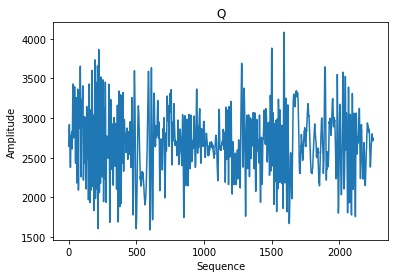

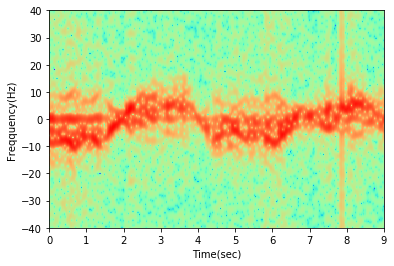

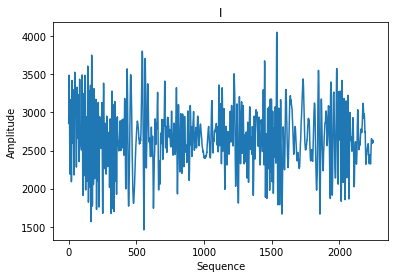

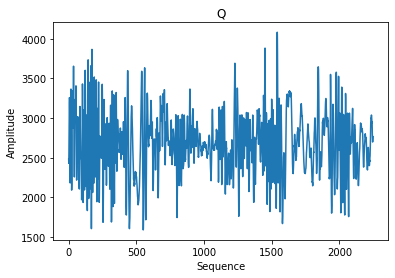

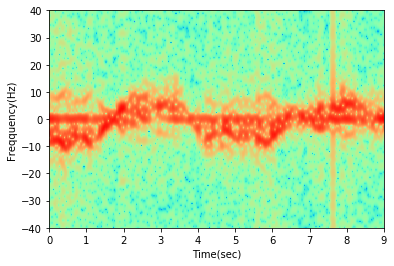

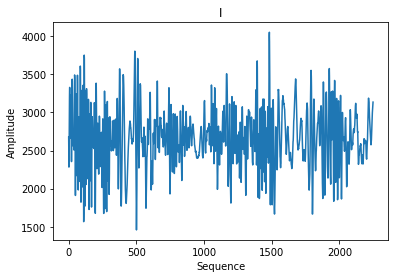

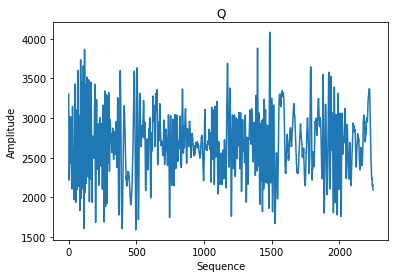

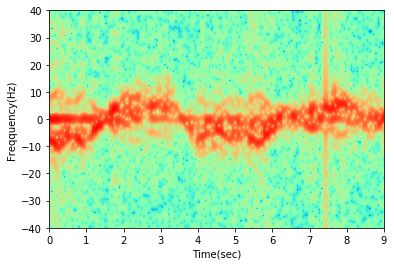

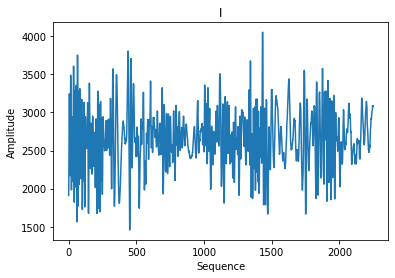

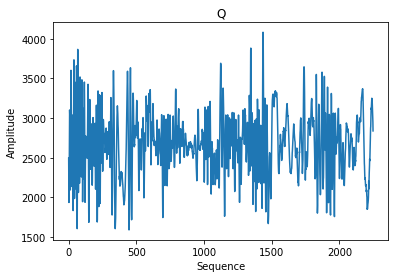

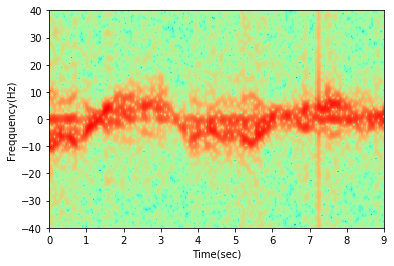

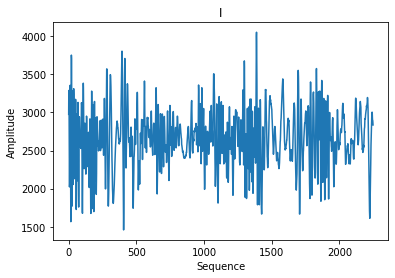

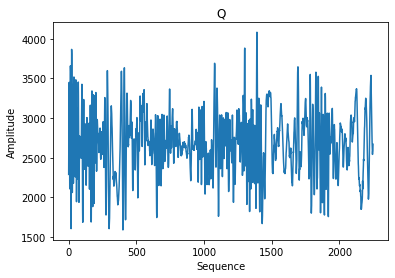

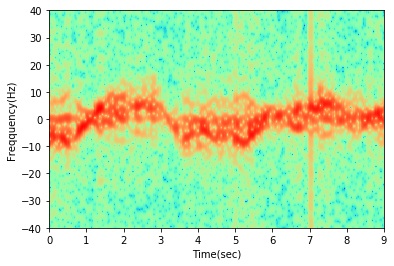

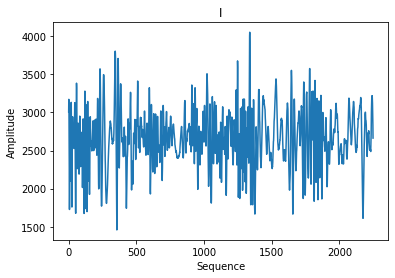

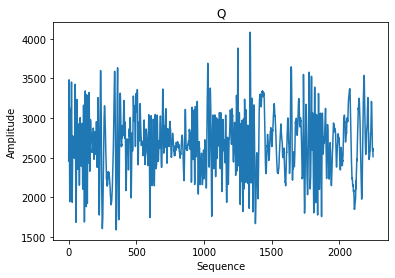

In [5]:
PrimaryNode=1
SecondaryNode=3

client=pymongo.MongoClient('localhost',27017)
db=client['local']


collections=db.collection_names(include_system_collections=False)
collections = filter(lambda x:x.startswith("BumblebeeKitchen_26_09_2018"), collections)
for collect in collections:
    print(collect)
    print(" ")
    collection0=db[collect]
    sequences= collection0.distinct("SequenceID",{'Behaviour':6})
    lsize=int(len(sequences)/4)
    s1=sequences[0:lsize]
    s2=sequences[lsize:lsize*2]
    s3=sequences[lsize*2:lsize*3]
    s4=sequences[lsize*3::]
    print(sequences)
    print(s1)
    t1 = threading.Thread(target=getsamples, args=(s1,collect,collection0,))
    t1.start()
    t2 = threading.Thread(target=getsamples, args=(s2,collect,collection0,))
    t2.start()
    t3 = threading.Thread(target=getsamples, args=(s3,collect,collection0,))
    t3.start()
    t4 = threading.Thread(target=getsamples, args=(s4,collect,collection0,))
    t4.start()
    print('\n')